# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [4]:
sns.set_style('whitegrid')

In [5]:
np.random.seed(42)

In [6]:
YEAR = 252
idx = pd.IndexSlice

In [7]:
DATA_DIR = Path('..', 'data')

In [8]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Get Data

In [9]:
data = pd.read_hdf('data.h5', 'us/alt_energy_forest/equities', free_raw_data=False)
data.index.set_names(["Ticker", "date"], inplace=True)
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5040 entries, ('BE', Timestamp('2019-01-07 00:00:00')) to ('VWSYF', Timestamp('2021-01-05 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ret_1            5030 non-null   float64
 1   ret_rel_perc_1   5030 non-null   float64
 2   ret_5            4990 non-null   float64
 3   ret_rel_perc_5   4990 non-null   float64
 4   ret_10           4940 non-null   float64
 5   ret_rel_perc_10  4940 non-null   float64
 6   ret_21           4830 non-null   float64
 7   ret_rel_perc_21  4830 non-null   float64
 8   ret_63           4410 non-null   float64
 9   ret_rel_perc_63  4410 non-null   float64
 10  PPO              4790 non-null   float64
 11  NATR             4900 non-null   float64
 12  RSI              4900 non-null   float64
 13  bbl              5000 non-null   float64
 14  bbu              5000 non-null   float64
 15  weekday          5040 non-nu

## MultipleTimeSeriesCV

In [11]:
cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=150)

In [12]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()}-{train_dates.max().date()} '
    msg += f' ({train.groupby(level="Ticker").size().value_counts().index[0]:,.0f} days) | '
    msg += f'Test: {test_dates.min().date()}-{test_dates.max().date()} '
    msg += f'({test.groupby(level="Ticker").size().value_counts().index[0]:,.0f} days)'
    print(msg)
    if i == 3:
        break

Training: 2020-04-22-2020-11-27  (154 days) | Test: 2020-12-04-2021-01-05 (21 days)
Training: 2020-03-23-2020-10-28  (154 days) | Test: 2020-11-04-2020-12-03 (21 days)
Training: 2020-02-21-2020-09-29  (154 days) | Test: 2020-10-06-2020-11-03 (21 days)
Training: 2020-01-22-2020-08-28  (154 days) | Test: 2020-09-04-2020-10-05 (21 days)


## Model Selection: Time Period and Horizon

Persist the data to save some time when running another experiment:

We're picking prediction horizons of 1, 5, 10 and 21 days:

In [15]:
lookaheads = [1, 5, 10, 21]

## Baseline: Linear Regression

In [16]:
lr = LinearRegression()

In [17]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

### CV Parameters

We set five different training lengths from 10 days months to 3 months, and two test periods as follows:

In [18]:
train_lengths = [60, 50, 40, 30, 20, 10]
test_lengths = [5, 21]

Since linear regression has no hyperparameters, our CV parameters are the cartesian product of prediction horizon and train/test period lengths:

In [19]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

Now we iterate over these parameters and train/validate the linear regression model while capturing the information coefficient of the model predictions, measure both on a daily basis and for each complete fold:

In [20]:
lr_metrics = []
for lookahead, train_length, test_length in test_params:
    label = f'fwd_ret_{lookahead:02}'
    df = data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = 3
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

In [21]:
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     48 non-null     int64  
 1   train_length  48 non-null     int64  
 2   test_length   48 non-null     int64  
 3   ic_by_day     48 non-null     float64
 4   ic            48 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 2.0 KB


### Information Coefficient distribution by Lookahead

Convert the data to long `seaborn`-friendly format:

In [22]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1)
                              .rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Day')),
                             lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Measure']
lr_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 47
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lookahead     96 non-null     int64  
 1   Train Length  96 non-null     int64  
 2   Test Length   96 non-null     int64  
 3   IC            96 non-null     float64
 4   Measure       96 non-null     object 
dtypes: float64(1), int64(3), object(1)
memory usage: 4.5+ KB


Plot both IC measures for the various CV parameters:

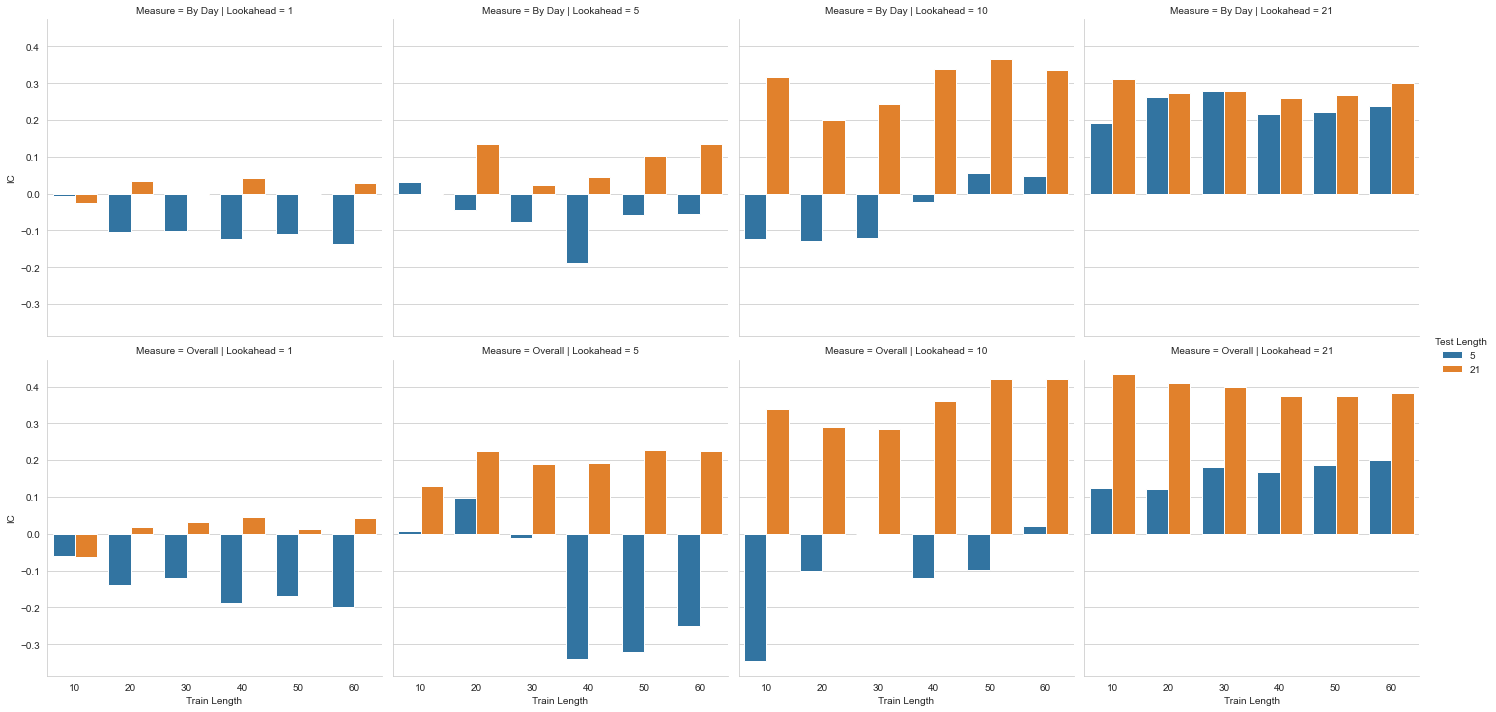

In [23]:
sns.catplot(x='Train Length',
            y='IC',
            hue='Test Length',
            col='Lookahead',
            row='Measure',
            data=lr_metrics_long,
            kind='bar')

Compare the distributions of each IC metric for the different prediction horizons:

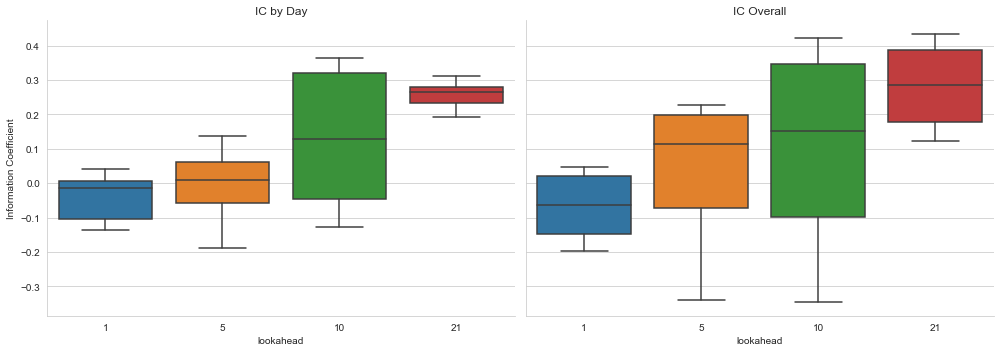

In [24]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
sns.despine()
fig.tight_layout()

### Best Train/Test Period Lengths

Show the best train/test period settings for the four prediction horizons:

In [25]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
5,1,40,21,0.041608,0.046220
1,1,60,21,0.028411,0.043734
7,1,30,21,-0.003296,0.031797
15,5,50,21,0.101867,0.226292
13,5,60,21,0.136248,0.224139
21,5,20,21,0.133669,0.224035
27,10,50,21,0.364772,0.421542
25,10,60,21,0.336225,0.421170
29,10,40,21,0.339172,0.361671
47,21,10,21,0.311454,0.434467


In [26]:
lr_metrics.to_csv(results_path / 'lin_reg_performance.csv', index=False)

## LightGBM Random Forest Model Tuning

Helper function to obtain the LightGBM feature importance metrics:

In [27]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

LightGBM base parameter settings that are independent of hyperparameter tuning:

In [28]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

### Hyperparameter Options

We run this experiment with different parameters for the bagging and feature fractions that determine the degree of randomization as well as the minimum number of samples for a split to control overfitting:

In [29]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [5, 25, 50, 100]

In [30]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

24

#### Random Sample

To limit the running time, we can randomly sample a subset of the parameter combinations (here: 50%):

In [31]:
sample_proportion = .5
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)), 
                                     size=int(sample_size), 
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 12


We tune the number of trees by evaluating a fully grown forest for various smaller sizes:

In [32]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

### Train/Test Period Lenghts

As above for linear regression, we define a range of train/test period length:

#### Define parameters

In [33]:
train_lengths = [60, 50, 40, 30, 20, 10]
test_lengths = [7, 14]

In [34]:
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)

#### Random sample

Just as for the model parameters, we can randomly sample from the 5 x 2 = 8 training configurations (here: 50%):

In [35]:
sample_proportion = 1.0
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(n_test_params)), 
                                     size=int(sample_size), 
                                     replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params_))
print('CV Iterations:', len(cv_params_) * len(test_params_))

Train configs: 12
CV Iterations: 144


### Categorical Variables

To leverage LightGBM's ability to handle categorical variables, we need to define them; we'll also `factorize` them so they are both integer-encoded and start at zero (optional, but otherwise throws a warning) as expected by LightGBM:

In [36]:
categoricals = ['weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Run Cross-Validation

Set up some helper variabels and storage locations to faciliate the CV process and result storage:

In [37]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

In [38]:
label_dict = dict(zip(lookaheads, labels))

In [39]:
cv_store = Path(results_path / 'parameter_tuning.h5')

In [40]:
ic_cols = ['bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't'] + [str(n) for n in num_iterations]

Now we take the following steps:
- we iterate over the prediction horizons and train/test period length, 
- set up the `MultipleTimeSeriesCV` accordingly
- create the binary LightGBM dataset with the appropriate target, and
- iterate over the model hyperparamters to train and validate the model while capturing the relevant performance metrics:

In [41]:
for lookahead in lookaheads:
    for train_length, test_length in test_params_:
        n_splits = 2
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
              f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  train_period_length=train_length,
                                  lookahead=lookahead)

        label = label_dict[lookahead]
        outcome_data = data.loc[:, features + [label]].dropna()

        lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                               label=outcome_data[label],
                               #categorical_feature=categoricals,
                               free_raw_data=False)
        
        predictions, daily_ic, ic, feature_importance = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0
        for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
            params = base_params.copy()
            params.update(dict(bagging_fraction=bagging_fraction,
                               feature_fraction=feature_fraction,
                               min_data_in_leaf=min_data_in_leaf))

            start = time()
            cv_preds, nrounds = [], []
            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                
                lgb_train = lgb_data.subset(train_idx.tolist()).construct()
                lgb_test = lgb_data.subset(test_idx.tolist()).construct()

                model = lgb.train(params=params,
                                  train_set=lgb_train,
                                  num_boost_round=num_boost_round,
                                  verbose_eval=False)
                if i == 0:
                    fi = get_fi(model).to_frame()
                else:
                    fi[i] = get_fi(model)

                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_name()]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, num_iteration=n)
                          for n in num_iterations}
                cv_preds.append(y_test.to_frame(
                    'y_test').assign(**y_pred).assign(i=i))
                nrounds.append(model.best_iteration)
            feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                               feature_fraction=feature_fraction,
                                                               min_data_in_leaf=min_data_in_leaf))
            cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                                  feature_fraction=feature_fraction,
                                                  min_data_in_leaf=min_data_in_leaf)

            predictions.append(cv_preds)
            by_day = cv_preds.groupby(level='date')
            ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test,
                                                                    x[str(n)])[0]).to_frame(n)
                                   for n in num_iterations], axis=1)

            daily_ic.append(ic_by_day.assign(bagging_fraction=bagging_fraction,
                                             feature_fraction=feature_fraction,
                                             min_data_in_leaf=min_data_in_leaf))

            cv_ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
                  for n in num_iterations]

            T += time() - start
            ic.append([bagging_fraction, feature_fraction,
                       min_data_in_leaf, lookahead] + cv_ic)

            msg = f'{p:3.0f} | {format_time(T)} | '
            msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
            msg += f'{max(cv_ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {ic_by_day.median().max(): 6.2%}'
            print(msg)

        m = pd.DataFrame(ic, columns=ic_cols)
        m.to_hdf(cv_store, 'ic/' + key)
        pd.concat(daily_ic).to_hdf(cv_store, 'daily_ic/' + key)
        pd.concat(feature_importance).to_hdf(cv_store, 'fi/' + key)
        pd.concat(predictions).to_hdf(cv_store, 'predictions/' + key)

Lookahead:  1 | Train:  30 | Test: 14 | Params:  12
  0 | 00:00:02 | 75% | 75% |     5 |  2.82% |  0.65% |  0.61%
  1 | 00:00:05 | 95% | 75% |     5 |  4.15% |  3.85% | -1.82%
  2 | 00:00:07 | 50% | 75% |     5 | 10.50% |  7.92% |  9.70%
  3 | 00:00:08 | 95% | 75% |    50 |  1.35% |  3.58% |  14.55%
  4 | 00:00:09 | 75% | 75% |   100 |  1.11% |  4.24% |  0.31%
  5 | 00:00:10 | 75% | 75% |    25 |  2.04% |  1.90% |  1.82%
  6 | 00:00:11 | 75% | 95% |    25 |  5.69% |  4.27% |  4.85%
  7 | 00:00:12 | 50% | 75% |    25 | -0.01% |  1.30% |  6.06%
  8 | 00:00:13 | 95% | 95% |    25 |  7.30% |  1.77% |  10.30%
  9 | 00:00:14 | 50% | 95% |    25 |  2.34% |  2.38% |  6.06%
 10 | 00:00:15 | 50% | 75% |    50 |  4.59% | -0.35% |  0.61%
 11 | 00:00:17 | 75% | 95% |     5 |  4.16% |  6.19% |  7.27%
Lookahead:  1 | Train:  40 | Test:  7 | Params:  12
  0 | 00:00:01 | 75% | 75% |     5 | -9.38% |  5.28% |  8.48%
  1 | 00:00:03 | 95% | 75% |     5 | -18.13% | -2.86% | -6.67%
  2 | 00:00:04 | 50% | 75

  2 | 00:00:04 | 50% | 75% |     5 | -3.61% | -1.86% |  1.21%
  3 | 00:00:05 | 95% | 75% |    50 | -2.57% |  3.65% |  6.37%
  4 | 00:00:05 | 75% | 75% |   100 |   nan% |   nan% |   nan%
  5 | 00:00:06 | 75% | 75% |    25 | -1.79% | -0.65% |  6.06%
  6 | 00:00:07 | 75% | 95% |    25 |  0.85% |  1.84% |  7.27%
  7 | 00:00:08 | 50% | 75% |    25 | -3.11% |  2.19% |  4.85%
  8 | 00:00:09 | 95% | 95% |    25 |  1.64% |  4.20% |  14.55%
  9 | 00:00:10 | 50% | 95% |    25 | -3.39% |  2.69% |  9.09%
 10 | 00:00:10 | 50% | 75% |    50 | -1.47% |  3.17% | -1.79%
 11 | 00:00:12 | 75% | 95% |     5 |  1.50% |  1.86% |  3.03%
Lookahead:  1 | Train:  10 | Test: 14 | Params:  12
  0 | 00:00:01 | 75% | 75% |     5 | -7.47% |  4.24% |  16.97%
  1 | 00:00:02 | 95% | 75% |     5 | -6.93% |  2.29% |  9.70%
  2 | 00:00:03 | 50% | 75% |     5 | -7.15% |  5.97% |  16.36%
  3 | 00:00:04 | 95% | 75% |    50 |   nan% | -0.27% | -4.50%
  4 | 00:00:04 | 75% | 75% |   100 |   nan% |   nan% |   nan%
  5 | 00:00:05 

  5 | 00:00:05 | 75% | 75% |    25 |  9.62% | -9.44% | -3.03%
  6 | 00:00:05 | 75% | 95% |    25 |  6.52% | -6.84% |  3.64%
  7 | 00:00:06 | 50% | 75% |    25 | -2.22% | -11.86% | -5.45%
  8 | 00:00:07 | 95% | 95% |    25 |  7.89% | -2.68% |  8.48%
  9 | 00:00:07 | 50% | 95% |    25 | -5.13% | -7.01% |  4.24%
 10 | 00:00:08 | 50% | 75% |    50 | -12.40% | -9.52% | -10.01%
 11 | 00:00:09 | 75% | 95% |     5 | 20.31% | -5.02% | -9.09%
Lookahead:  5 | Train:  40 | Test: 14 | Params:  12
  0 | 00:00:01 | 75% | 75% |     5 | 15.92% |  2.16% | -1.82%
  1 | 00:00:03 | 95% | 75% |     5 | 13.87% | -2.21% | -8.48%
  2 | 00:00:04 | 50% | 75% |     5 | 13.21% |  4.85% |  0.61%
  3 | 00:00:05 | 95% | 75% |    50 | 20.55% |  9.48% |  5.45%
  4 | 00:00:06 | 75% | 75% |   100 |  8.57% |  5.67% |  13.37%
  5 | 00:00:07 | 75% | 75% |    25 | 19.45% |  4.55% |  2.42%
  6 | 00:00:08 | 75% | 95% |    25 | 19.20% |  3.68% |  3.64%
  7 | 00:00:09 | 50% | 75% |    25 | 19.51% |  9.44% |  6.06%
  8 | 00:00:10

  7 | 00:00:08 | 50% | 75% |    25 | 20.17% |  8.40% |  9.09%
  8 | 00:00:08 | 95% | 95% |    25 | 25.64% |  18.61% |  18.18%
  9 | 00:00:09 | 50% | 95% |    25 | 20.43% |  10.82% |  9.09%
 10 | 00:00:10 | 50% | 75% |    50 |  8.82% | -0.26% |  12.12%
 11 | 00:00:11 | 75% | 95% |     5 | 19.99% |  11.43% |  19.39%
Lookahead: 10 | Train:  60 | Test:  7 | Params:  12
  0 | 00:00:01 | 75% | 75% |     5 | 20.43% |  11.43% |  14.55%
  1 | 00:00:03 | 95% | 75% |     5 | 15.53% |  12.64% |  20.00%
  2 | 00:00:04 | 50% | 75% |     5 | 18.40% |  13.77% |  15.76%
  3 | 00:00:05 | 95% | 75% |    50 | 21.11% |  13.33% |  17.58%
  4 | 00:00:06 | 75% | 75% |   100 |  9.46% |  4.33% |  7.27%
  5 | 00:00:06 | 75% | 75% |    25 | 23.37% |  13.51% |  13.94%
  6 | 00:00:07 | 75% | 95% |    25 | 17.53% |  15.41% |  21.21%
  7 | 00:00:08 | 50% | 75% |    25 | 24.33% |  14.11% |  14.55%
  8 | 00:00:09 | 95% | 95% |    25 | 19.11% |  18.35% |  24.85%
  9 | 00:00:10 | 50% | 95% |    25 | 20.74% |  13.94% |  1

  9 | 00:00:12 | 50% | 95% |    25 | 13.23% |  19.22% |  26.06%
 10 | 00:00:13 | 50% | 75% |    50 |  8.54% |  13.31% |  18.79%
 11 | 00:00:15 | 75% | 95% |     5 | 12.04% |  18.34% |  19.12%
Lookahead: 21 | Train:  30 | Test:  7 | Params:  12
  0 | 00:00:01 | 75% | 75% |     5 | 22.59% |  20.52% |  21.21%
  1 | 00:00:02 | 95% | 75% |     5 | 12.33% |  10.30% |  9.09%
  2 | 00:00:04 | 50% | 75% |     5 | 25.83% |  24.33% |  30.30%
  3 | 00:00:05 | 95% | 75% |    50 |  7.73% |  2.86% |  1.82%
  4 | 00:00:06 | 75% | 75% |   100 | -26.09% | -28.35% | -23.11%
  5 | 00:00:07 | 75% | 75% |    25 | 14.46% |  10.30% |  17.58%
  6 | 00:00:08 | 75% | 95% |    25 |  9.14% |  4.76% |  11.52%
  7 | 00:00:09 | 50% | 75% |    25 | 12.45% |  6.06% |  13.33%
  8 | 00:00:10 | 95% | 95% |    25 | 10.64% |  8.31% |  9.70%
  9 | 00:00:11 | 50% | 95% |    25 | 13.76% |  6.49% |  15.15%
 10 | 00:00:12 | 50% | 75% |    50 | -4.12% | -5.19% |  0.00%
 11 | 00:00:15 | 75% | 95% |     5 | 22.03% |  16.28% |  24.8

## Analyse Cross-Validation Results

### Collect Data

We'll now combine the CV results that we stored separately for each fold (to avoid loosing results in case something goes wrong along the way):

In [42]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

We'll look at the financial performance in the notebook `alphalens_signal_quality`.

In [43]:
daily_ic, ic = [], []
for t in lookaheads:
    print(t)
    with pd.HDFStore(cv_store) as store:
        keys = [k[1:] for k in store.keys() if k.startswith(f'/fi/{t}')]
        for key in keys:
            train_length, test_length = key.split('/')[2:]
            print(train_length, test_length)
            k = f'{t}/{train_length}/{test_length}'
            cols = {'t': t,
                    'train_length': int(train_length),
                    'test_length': int(test_length)}

            ic.append(pd.melt(store['ic/' + k]
                              .assign(**cols),
                              id_vars=id_vars[:-1],
                              value_name='ic',
                              var_name='rounds')
                      .apply(pd.to_numeric))

            df = store['daily_ic/' + k].assign(**cols).reset_index()
            daily_ic.append(pd.melt(df,
                                    id_vars=id_vars,
                                    value_name='daily_ic',
                                    var_name='rounds')
                            .set_index('date')
                            .apply(pd.to_numeric)
                            .reset_index())            
ic = pd.concat(ic, ignore_index=True)
daily_ic = pd.concat(daily_ic, ignore_index=True)

1
60 14
60 7
50 14
50 7
40 14
40 7
30 14
30 7
20 14
20 7
10 14
10 7
60 14
60 7
50 14
50 7
40 14
40 7
30 14
30 7
20 14
20 7
10 14
10 7
5
60 14
60 7
50 14
50 7
40 14
40 7
30 14
30 7
20 14
20 7
10 14
10 7
10
60 14
60 7
50 14
50 7
40 14
40 7
30 14
30 7
20 14
20 7
10 14
10 7
21
60 14
60 7
50 14
50 7
40 14
40 7
30 14
30 7
20 14
20 7
10 14
10 7


### Predictive Performance: CV Information Coefficient by Day

In [44]:
group_cols = ['t','train_length', 'test_length', 
              'bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
daily_ic_avg = daily_ic.groupby(group_cols + ['rounds']).daily_ic.mean().to_frame('ic').reset_index()
daily_ic_avg.groupby('t', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
660,1,20,7,0.95,0.75,5,25,0.154113
661,1,20,7,0.95,0.75,5,50,0.135065
662,1,20,7,0.95,0.75,5,75,0.119481
5401,5,60,7,0.75,0.75,100,50,0.182684
4841,5,50,7,0.50,0.75,50,50,0.180952
4840,5,50,7,0.50,0.75,50,25,0.175758
7180,10,30,14,0.95,0.95,25,25,0.292614
7863,10,50,7,0.95,0.75,5,100,0.289177
7199,10,30,14,0.95,0.95,25,500,0.277324
10520,21,40,14,0.95,0.75,50,25,0.351708


In [45]:
daily_ic_avg.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11520 entries, 0 to 11519
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 11520 non-null  int64  
 1   train_length      11520 non-null  int64  
 2   test_length       11520 non-null  int64  
 3   bagging_fraction  11520 non-null  float64
 4   feature_fraction  11520 non-null  float64
 5   min_data_in_leaf  11520 non-null  int64  
 6   rounds            11520 non-null  int64  
 7   ic                11238 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 720.1 KB


For a 1-day forecast horizon, over 75% of the predictions yield a positive daily IC; the same is true for 21 days which, unsurprisingly, also shows a wider range.

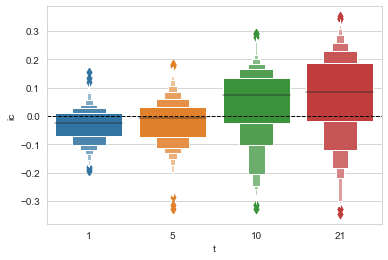

In [46]:
ax = sns.boxenplot(x='t', y='ic', data=daily_ic_avg)
ax.axhline(0, ls='--', lw=1, c='k');

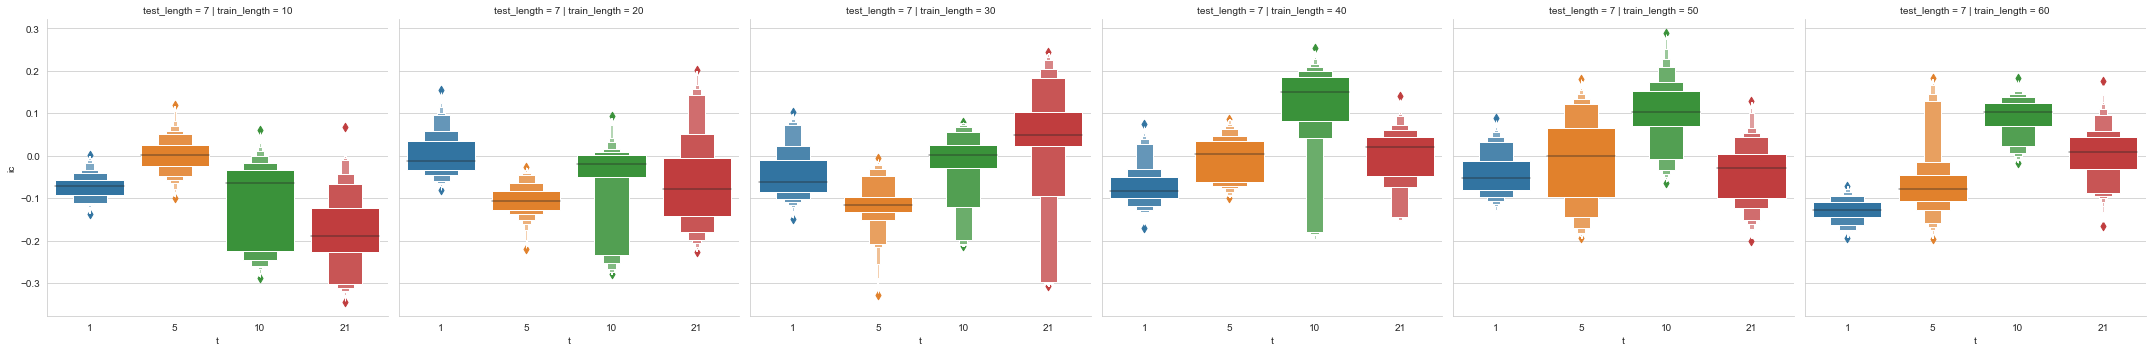

In [47]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=daily_ic_avg[(daily_ic_avg.test_length == 7)],
                kind='boxen')

g.savefig(results_path / 'daily_ic_test_21', dpi=300);

### HyperParameter Impact: Linear Regression

In [48]:
lin_reg = {}
for t in [1, 5]:
    df_ = daily_ic_avg[(daily_ic_avg.t==t)&(daily_ic_avg.rounds<=250)].dropna()
    y, X = df_.ic, df_.drop(['ic', 't'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(
        columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err',
                     't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(results_path / f'lr_result_{t:02}.csv', index=False)

In [49]:
def visualize_lr_result(model, ax):
    
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith(
        'date') & (coefs.variable != 'const')]
    coefs.variable = coefs.variable.str.split('_').str[-1]

    coefs.plot(x='variable', y='coef', kind='bar', ax=ax, 
               color='none', capsize=3, yerr='error', legend=False, rot=0)    
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

    ax.annotate('Train\nLength', xy=(.09, -0.1), xytext=(.09, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Test\nLength', xy=(.23, -0.1), xytext=(.23, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Bagging\nFraction', xy=(.32, -0.1), xytext=(.32, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.7, lengthB=0.8', lw=1.0, color='black'))


    ax.annotate('Feature\nFraction', xy=(.44, -0.1), xytext=(.44, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=3.4, lengthB=1.0', lw=1.0, color='black'))
    

    ax.annotate('Min.\nSamples', xy=(.55, -0.1), xytext=(.55, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.0', lw=1.0, color='black'))    
    
    ax.annotate('Number of\nRounds', xy=(.8, -0.1), xytext=(.8, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=11.2, lengthB=1.0', lw=1.0, color='black'))

The below plot shows the regression coefficient values and their confidence intervals. The intercept (not shown) has a small positive value and is statistically signifant; it captures the impact of the dropped categories (the smallest value for each parameter).

For 1-day forecasts, some but not all results are insightful: 21-day testing is better, and so is `min_samples_leaf` of 500 or 1,000. 100-200 trees seem to work best, but both shorter and longer training periods are better than intermediate values.

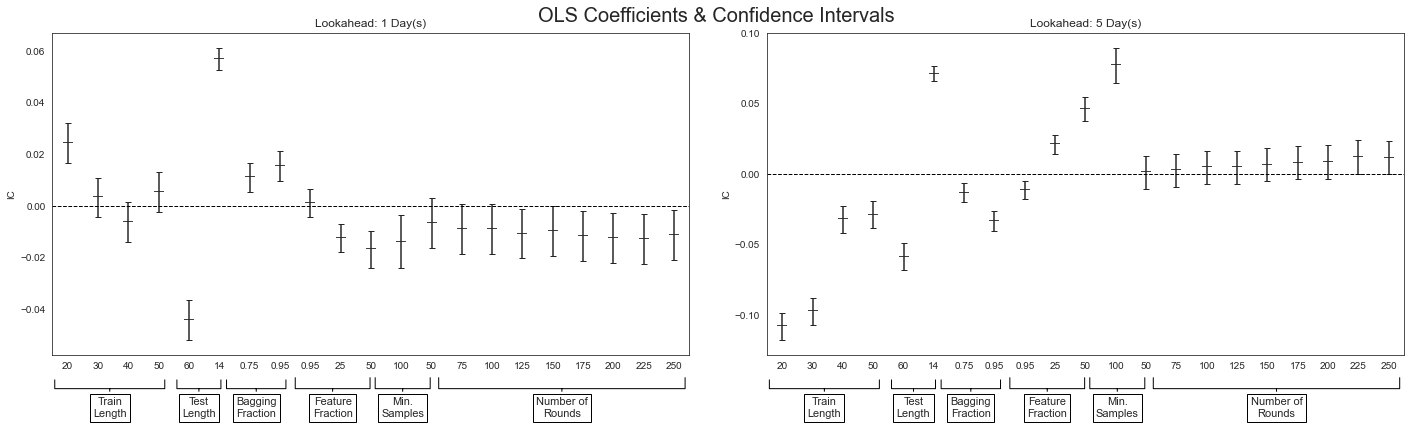

In [50]:
with sns.axes_style('white'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    axes = axes.flatten()
    for i, t in enumerate([1, 5]):
        visualize_lr_result(lin_reg[t], axes[i])
        axes[i].set_title(f'Lookahead: {t} Day(s)')
    fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.92)

### Information Coefficient: Overall

We'll also take a look at the overall IC value, which is often reported but does not necessarily match the goal of a daily trading strategy that uses the model return predictions as well as the daily IC.

In [51]:
ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_length      14400 non-null  int64  
 1   test_length       14400 non-null  int64  
 2   bagging_fraction  14400 non-null  float64
 3   feature_fraction  14400 non-null  float64
 4   min_data_in_leaf  14400 non-null  int64  
 5   t                 14400 non-null  int64  
 6   rounds            14400 non-null  int64  
 7   ic                13996 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 900.1 KB


#### Best Parameters

Directionally, and for shorter periods, similar hyperparameter settings work best (while the IC values are higher):

In [52]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  \
t                                                                         
1  85               60           14              0.95              0.75   
   2965             60           14              0.95              0.75   
   97               60           14              0.95              0.75   
5  8414             10            7              0.50              0.75   
   8438             10            7              0.50              0.75   
   8426             10            7              0.50              0.75   
10 8650             60           14              0.50              0.75   
   9385             50            7              0.95              0.75   
   8662             60           14              0.50              0.75   
21 12968            30           14              0.95              0.95   
   13442            20           14              0.50              0.75   
   12971            30           14              0.75              0.95   

          min_data_in_leaf   t  rounds        ic  
t                                                 
1  85                    5   1     200  0.108382  
   2965                  5   1     200  0.108382  
   97                    5   1     225  0.107838  
5  8414                  5   5      50  0.407133  
   8438                  5   5     100  0.395137  
   8426                  5   5      75  0.385826  
10 8650                 50  10      25  0.337772  
   9385                  5  10      75  0.333035  
   8662                 50  10      50  0.332002  
21 12968                25  21      25  0.298261  
   13442                 5  21      25  0.282100  
   12971                 5  21      25  0.277416

#### Visualiztion

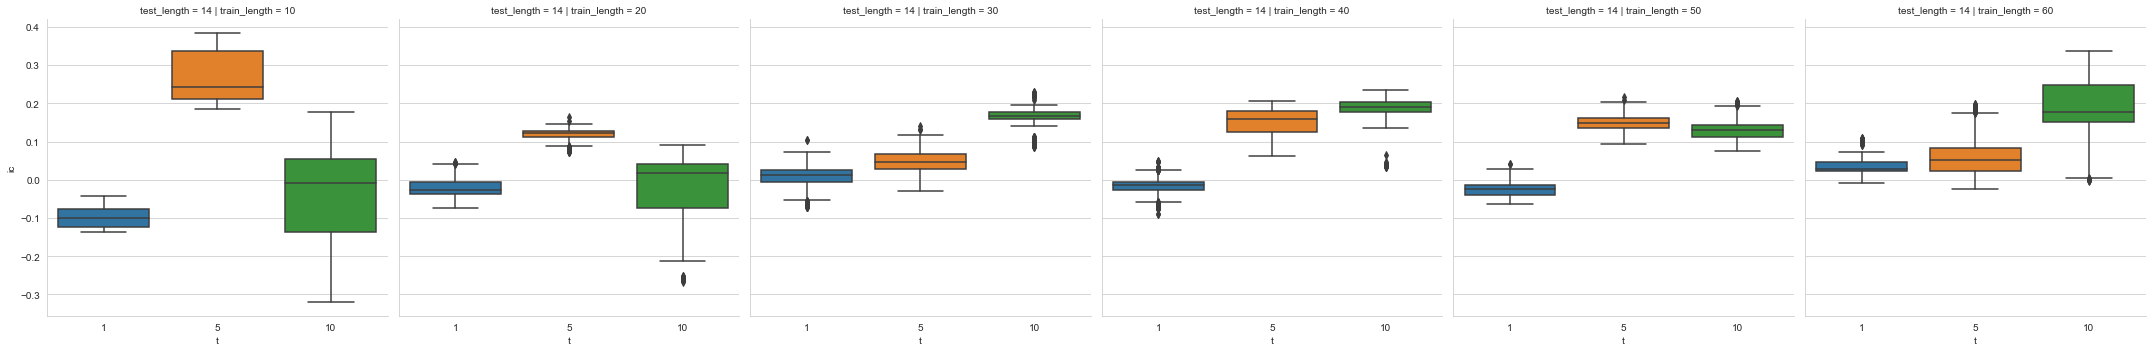

In [53]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == 14) & (ic.t < 14)],
                kind='box')

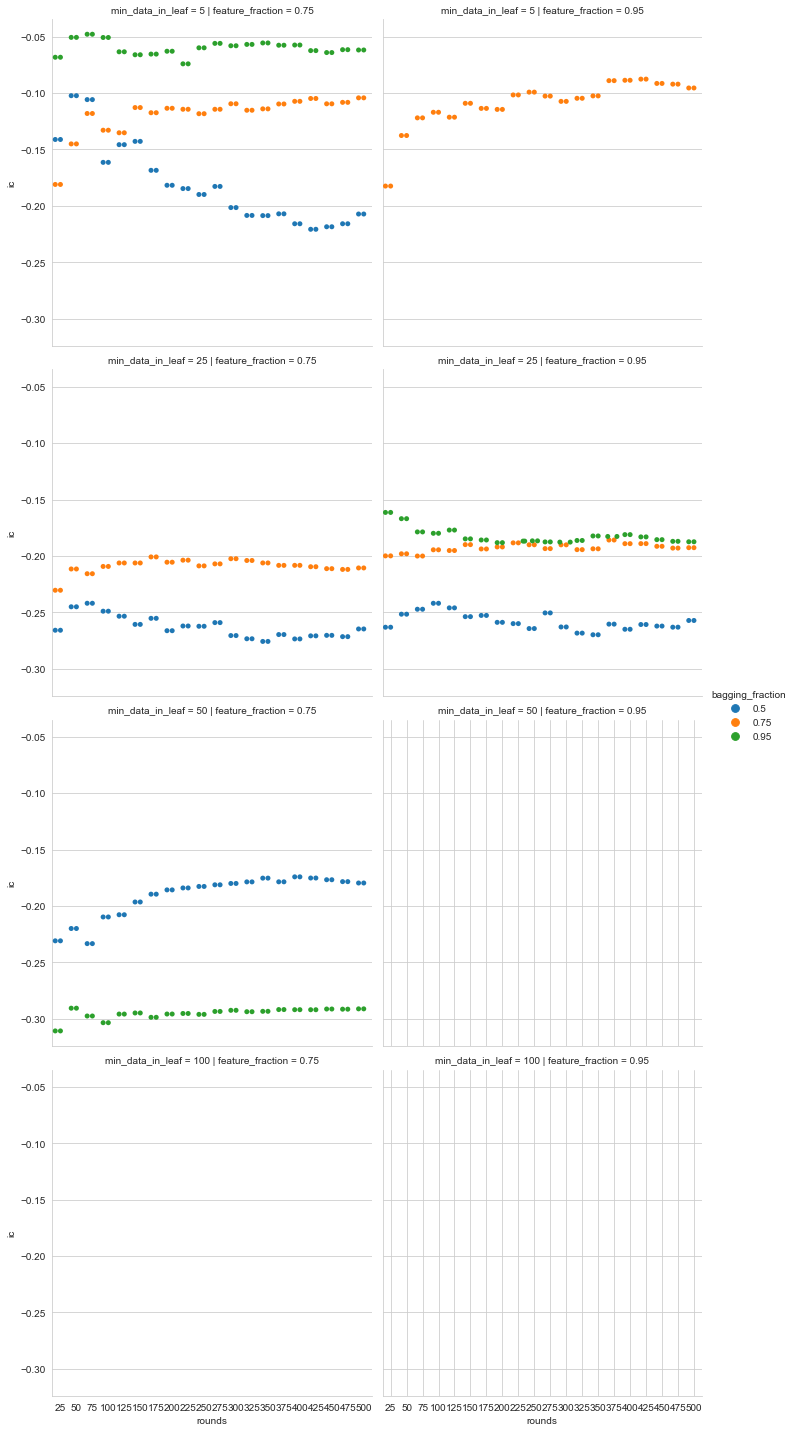

In [54]:
t = 1
train_length = 20
test_length = 7
g = sns.catplot(x='rounds',
    y='ic',
    col='feature_fraction',
    hue='bagging_fraction',
    row='min_data_in_leaf',
    data=ic[(ic.t == t) &
            (ic.train_length == train_length) &
            (ic.test_length == test_length)],
    kind='swarm');

### Random Forest vs Linear Regression 

Let's compare the best-performing (in-sample) random forest models to our linear regression baseline:

In [56]:
daily_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11520 entries, 0 to 11519
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 11520 non-null  int64  
 1   train_length      11520 non-null  int64  
 2   test_length       11520 non-null  int64  
 3   bagging_fraction  11520 non-null  float64
 4   feature_fraction  11520 non-null  float64
 5   min_data_in_leaf  11520 non-null  int64  
 6   rounds            11520 non-null  int64  
 7   ic                11238 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 720.1 KB


The results are mixed: for the shortest and longest horizons, the random forest outperforms (slightly for 1 day), while linear regression is competitive for the intermediate horizons:

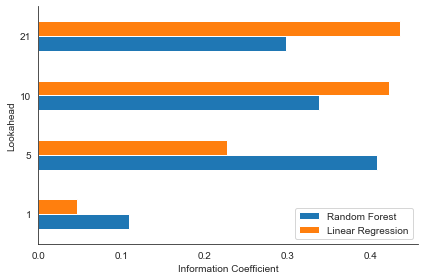

In [57]:
with sns.axes_style("white"):
    ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
     .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
    ax.set_ylabel('Lookahead')
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout();

## Generate predictions

In [58]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

In [59]:
def get_params(data, t=2, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

In [60]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

store = ('/Users/chris/Desktop/Stocks/Decision_Tree/results/predictions.h5')

In [61]:
print(int(params['min_data_in_leaf']))

5


In [62]:
for lookahead in [1, 5, 10, 21]:
    
    if lookahead > 1: 
        continue
        
    print(f'\nLookahead: {lookahead:02}')
    
    data = (pd.read_hdf('data.h5', 'us/alt_energy_fores/equities').dropna())
    data.index.set_names(["Ticker", "date"], inplace=True)
    
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.reindex(columns = features + [label])
    #data = data.loc[:, features + [label]].dropna()

    categoricals = ['weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           #categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(10):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(15)
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'\tPosition: {position:02}')

        n_splits = 5
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            lgb_train = lgb_data.subset(train_idx.tolist()).construct()

            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)

            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))

        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        

    by_day = test_predictions.groupby(level='date')
    for position in range(10):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])

    test_predictions.to_hdf(store, f'test/{lookahead:02}')


Lookahead: 01
	Position: 00
	Position: 01
	Position: 02
	Position: 03
	Position: 04
	Position: 05
	Position: 06
	Position: 07
	Position: 08
	Position: 09
